### Test de modélisation avec un algo de classification "classique"

* Mise en oeuvre d'un réseau de neurones dense "simple"
* Application du tuto : https://www.tensorflow.org/tutorials/images/classification

### Import librairies

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import time
import os
import pathlib
import shutil
import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential

### Sélection d'un jeu de données trié uniquement en 2 classes : NORMAL et PNEUMONIE (3 autres)

In [11]:
#Jeu copié à la main depuis Train_val_1

### 1er réseau de neurones denses

In [6]:
#1 : Import du dataset et compte des images
dossier_train = "../../Data/Train_val_set_2/"
data_dir = pathlib.Path(dossier_train).with_suffix('')
image_count = len(list(data_dir.glob('*/*.png')))
print(f"{image_count} images dans le dataset")

900 images dans le dataset


In [7]:
#2 : Chargement du dataset dans Keras
#define parameters for loader
batch_size = 32
img_height = 256
img_width = 256


#Create train set 80%
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = "grayscale")

#Create validation set 20%
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = "grayscale")


Found 900 files belonging to 2 classes.
Using 720 files for training.
Found 900 files belonging to 2 classes.
Using 180 files for validation.


In [8]:
#You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMO']


In [9]:
#Configure dataset for performance with CACHE (not loading images at each epoch) and PREFETCH (overlapping data processing and model execution)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
#STandardize layer as part of model
#Here, you will standardize values to be in the [0, 1] range by using 
normalization_layer = layers.Rescaling(1./255)

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 1)
(32,)


In [11]:
#Instanciation d'un premier modèle avec 2 couches 

num_classes = len(class_names)
#inputs = layers.Rescaling(1./255, input_shape=(img_height, img_width))
#first_layer = layers.Dense(16, activation = "tanh", kernel_initializer = "normal", name = "Dense1")
#second_layer = layers.Dense(4, activation = "softmax", kernel_initializer = "normal", name = "Dense2")
#x = first_layer(inputs)
#outputs = second_layer(x)
#model = Model(inputs = inputs, outputs = outputs)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Flatten(),
  layers.Dense(128, activation='relu', name = "Dense2"),
  layers.Dense(32, activation='relu', name = "Dense5"),
  layers.Dense(num_classes, activation = "softmax", name = "Dense6")
])

#Compiler le modèle
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [12]:
#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 1)       0         
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 Dense2 (Dense)              (None, 128)               8388736   
                                                                 
 Dense5 (Dense)              (None, 32)                4128      
                                                                 
 Dense6 (Dense)              (None, 2)                 66        
                                                                 
Total params: 8392930 (32.02 MB)
Trainable params: 8392930 (32.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
#Entraînement du modèle

#Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#Train model
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
#  callbacks = [callback]
)

Epoch 1/30




23/23 [==============================] - 7s 213ms/step - loss: 0.9689 - accuracy: 0.5708 - val_loss: 0.6905 - val_accuracy: 0.6667
Epoch 2/30
23/23 [==============================] - 3s 140ms/step - loss: 0.5135 - accuracy: 0.7472 - val_loss: 0.8234 - val_accuracy: 0.6722
Epoch 3/30
23/23 [==============================] - 3s 138ms/step - loss: 0.4379 - accuracy: 0.7944 - val_loss: 0.6752 - val_accuracy: 0.7667
Epoch 4/30
23/23 [==============================] - 3s 134ms/step - loss: 0.3641 - accuracy: 0.8403 - val_loss: 0.6913 - val_accuracy: 0.7056
Epoch 5/30
23/23 [==============================] - 3s 146ms/step - loss: 0.2968 - accuracy: 0.8681 - val_loss: 0.7266 - val_accuracy: 0.7333
Epoch 6/30
23/23 [==============================] - 3s 152ms/step - loss: 0.2705 - accuracy: 0.8903 - val_loss: 0.7510 - val_accuracy: 0.7500
Epoch 7/30
23/23 [==============================] - 3s 131ms/step - loss: 0.1983 - accuracy: 0.9250 - val_loss: 0.7293 - val_accuracy: 0.7167
Epoch 8/30
23/2

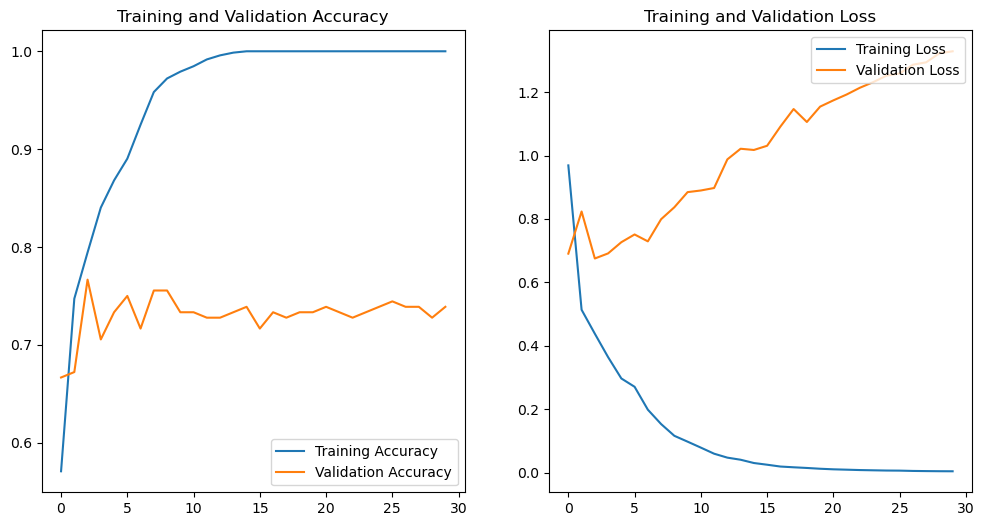

In [14]:
#Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()





### 2 Réseau de convolution

In [15]:
# Ajout de couches de convolution

num_classes = len(class_names)

model2 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu', name = "Dense2"),
  layers.Dense(32, activation='relu', name = "Dense5"),
  layers.Dense(num_classes, activation = "softmax", name = "Dense6")
])

#Compiler le modèle
model2.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

#model summary
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)      

In [16]:
#Entraînement du modèle

#Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#Train model
epochs=30
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [callback]
)

Epoch 1/30


23/23 [==============================] - 43s 2s/step - loss: 0.6627 - accuracy: 0.6208 - val_loss: 0.6125 - val_accuracy: 0.6722
Epoch 2/30
23/23 [==============================] - 42s 2s/step - loss: 0.5139 - accuracy: 0.7417 - val_loss: 0.5426 - val_accuracy: 0.7056
Epoch 3/30
23/23 [==============================] - 50s 2s/step - loss: 0.3942 - accuracy: 0.8556 - val_loss: 0.5696 - val_accuracy: 0.7222
Epoch 4/30
23/23 [==============================] - 41s 2s/step - loss: 0.2872 - accuracy: 0.8847 - val_loss: 0.5878 - val_accuracy: 0.7778
Epoch 5/30
23/23 [==============================] - 39s 2s/step - loss: 0.2038 - accuracy: 0.9222 - val_loss: 0.5525 - val_accuracy: 0.7722
Epoch 6/30
23/23 [==============================] - 34s 2s/step - loss: 0.1393 - accuracy: 0.9431 - val_loss: 0.7727 - val_accuracy: 0.7611
Epoch 7/30
23/23 [==============================] - 34s 1s/step - loss: 0.1300 - accuracy: 0.9486 - val_loss: 0.7553 - val_accuracy: 0.7833


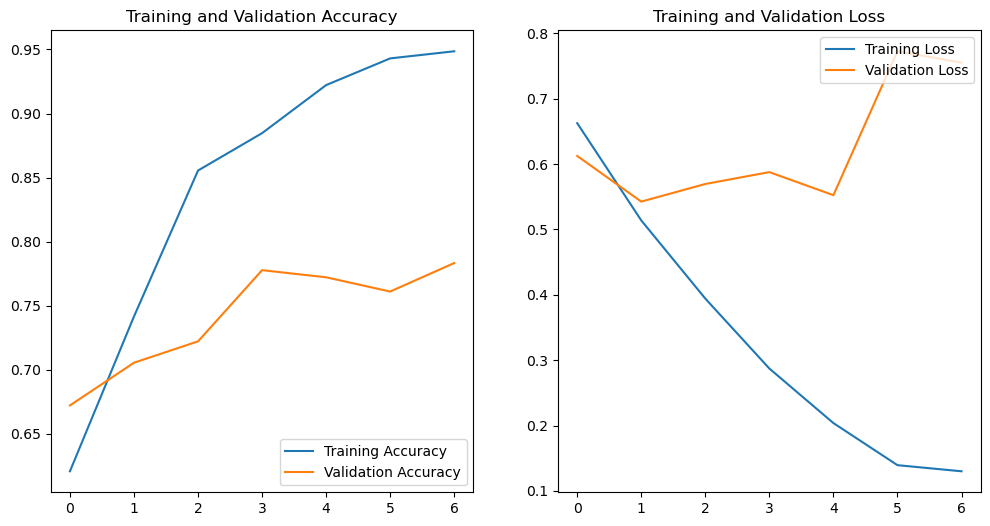

In [17]:
#Visualize training results
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



